# Data Science Workshop
# NBA Free Throws Prediction

![title](img/free_throw_img.jpg)

## Data preparation and cleaning

## Import Python Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline


## Reading the Original Dataset


In [2]:
free_throws_db = pd.read_csv('free_throws.csv')
free_throws_db.drop_duplicates()
free_throws_db.head(10)

,end_result,game,game_id,period,play,player,playoffs,score,season,shot_made,time
0,106 - 114,PHX - LAL,261031013,1,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,0 - 1,2006 - 2007,1,11:45
1,106 - 114,PHX - LAL,261031013,1,Andrew Bynum makes free throw 2 of 2,Andrew Bynum,regular,0 - 2,2006 - 2007,1,11:45
2,106 - 114,PHX - LAL,261031013,1,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,18-Dec,2006 - 2007,1,7:26
3,106 - 114,PHX - LAL,261031013,1,Andrew Bynum misses free throw 2 of 2,Andrew Bynum,regular,18-Dec,2006 - 2007,0,7:26
4,106 - 114,PHX - LAL,261031013,1,Shawn Marion makes free throw 1 of 1,Shawn Marion,regular,21-Dec,2006 - 2007,1,7:18
5,106 - 114,PHX - LAL,261031013,1,Amare Stoudemire makes free throw 1 of 2,Amare Stoudemire,regular,33 - 20,2006 - 2007,1,3:15
6,106 - 114,PHX - LAL,261031013,1,Amare Stoudemire makes free throw 2 of 2,Amare Stoudemire,regular,34 - 20,2006 - 2007,1,3:15
7,106 - 114,PHX - LAL,261031013,2,Leandro Barbosa misses free throw 1 of 2,Leandro Barbosa,regular,43 - 29,2006 - 2007,0,10:52
8,106 - 114,PHX - LAL,261031013,2,Leandro Barbosa makes free throw 2 of 2,Leandro Barbosa,regular,44 - 29,2006 - 2007,1,10:52
9,106 - 114,PHX - LAL,261031013,2,Lamar Odom makes free throw 1 of 2,Lamar Odom,regular,44 - 30,2006 - 2007,1,10:37


Describition of dataset:
- end_result: host total score - guest total score
- game: host team vs guest team
- game_id: id of specific game
- period: which quarter
- play: who make free throw, make or miss free throw
- player: player name
- playoffs: whether a playoff game or regular game
- score: host team score - guest team score at that time
- season: NBA season
- shot_made: whether player got the free throw
- time: time left in that quarter

In [3]:
print("Number of free throws in database: %d"%(free_throws_db.shape[0]))
print("Number of games in database: {}".format(free_throws_db.game_id.unique().size))
print("Games distribution:")
free_throws_db['playoffs'].value_counts()

Number of free throws in database: 618019
Number of games in database: 12874
Games distribution:


regular     575893
playoffs     42126
Name: playoffs, dtype: int64

## Collecting more data from internet

In order to expand our dataset, we decided to use an open source python library PandasBasketball, and use a webscrapper in order to get more players stats from https://www.basketball-reference.com website

In [4]:
from tools import get_player_stats
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='BeatifulSoup')
dataFrame = get_player_stats("Lebron James")
print(dataFrame.columns)
dataFrame.head(20)

Index(['Season', 'Age', 'Tm', 'Lg', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Height',
       'Weight', 'ShootingHand', 'draftRank'],
      dtype='object')


,Season,Age,Tm,Lg,Pos,G,GS,MP,FG,FGA,...,AST,STL,BLK,TOV,PF,PTS,Height,Weight,ShootingHand,draftRank
0,2003-04,19,CLE,NBA,SG,79,79,3122,622,1492,...,465,130,58,273,149,1654,206,113,Right,1
1,2004-05,20,CLE,NBA,SF,80,80,3388,795,1684,...,577,177,52,262,146,2175,206,113,Right,1
2,2005-06,21,CLE,NBA,SF,79,79,3361,875,1823,...,521,123,66,260,181,2478,206,113,Right,1
3,2006-07,22,CLE,NBA,SF,78,78,3190,772,1621,...,470,125,55,250,171,2132,206,113,Right,1
4,2007-08,23,CLE,NBA,SF,75,74,3027,794,1642,...,539,138,81,255,165,2250,206,113,Right,1
5,2008-09,24,CLE,NBA,SF,81,81,3054,789,1613,...,587,137,93,241,139,2304,206,113,Right,1
6,2009-10,25,CLE,NBA,SF,76,76,2966,768,1528,...,651,125,77,261,119,2258,206,113,Right,1
7,2010-11,26,MIA,NBA,SF,79,79,3063,758,1485,...,554,124,50,284,163,2111,206,113,Right,1
8,2011-12,27,MIA,NBA,SF,62,62,2326,621,1169,...,387,115,50,213,96,1683,206,113,Right,1
9,2012-13,28,MIA,NBA,PF,76,76,2877,765,1354,...,551,129,67,226,110,2036,206,113,Right,1


Columns used for this database for each player:
- Position : The most common position for the player over his seasons.
- FG%
- 3P%
- FT%
- Height
- Weight
- ShootingHand
- draftRank

## We merged both the datasets according our collected data from internet.
Some players stats had been inserted manually because some bugs found on PandasBasketball library

In [5]:
database_p1 = pd.read_csv("merged_db_part1.csv")
database_p2 = pd.read_csv("merged_db_part2.csv")

database = pd.concat([database_p1,database_p2])
database = database.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
# Drop duplicated rows
database.drop_duplicates()
database.head(5)

,end_result,game,game_id,period,play,player,playoffs,score,season,shot_made,time,FG%,2P%,3P%,FT%,Height,Weight,draftRank,Pos,ShootingHand
0,106 - 114,PHX - LAL,261031013,1,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,0 - 1,2006 - 2007,1,11:45,0.556,0.557,0.111,0.69,213,129,10.0,C,Right
1,106 - 114,PHX - LAL,261031013,1,Andrew Bynum makes free throw 2 of 2,Andrew Bynum,regular,0 - 2,2006 - 2007,1,11:45,0.556,0.557,0.111,0.69,213,129,10.0,C,Right
2,106 - 114,PHX - LAL,261031013,1,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,18-12,2006 - 2007,1,07:26,0.556,0.557,0.111,0.69,213,129,10.0,C,Right
3,106 - 114,PHX - LAL,261031013,1,Andrew Bynum misses free throw 2 of 2,Andrew Bynum,regular,18-12,2006 - 2007,0,07:26,0.556,0.557,0.111,0.69,213,129,10.0,C,Right
4,106 - 114,PHX - LAL,261031013,1,Shawn Marion makes free throw 1 of 1,Shawn Marion,regular,21-12,2006 - 2007,1,07:18,0.484,0.513,0.331,0.81,201,99,9.0,SF,Right


## Specifing Data Types

In [6]:
binary_variables = ['shot_made', 'playoffs', 'ShootingHand']
categorical_variables = ['end_result', 'game', 'game_id', 'period', 'play', 'player', 'season', 'Pos']
numeric_variables = ['score','time','FG%','2P%', '3P%', 'FT%', 'Height', 'Weight', 'draftRank']

In [7]:
database.count()

end_result      618019
game            618019
game_id         618019
period          618019
play            618019
player          618019
playoffs        618019
score           618019
season          618019
shot_made       618019
time            618019
FG%             618019
2P%             618019
3P%             612941
FT%             618019
Height          618019
Weight          618019
draftRank       579587
Pos             618019
ShootingHand    618019
dtype: int64

We can see, we have only two columns with missing data. First - the draftRank column. 
This values are missing because the players performed the free throw didn't have a draft rank and not because we couldn't collect the data. Second - 3P% has missing values since there are players that have never throws a 3-pointer.

### Analyzing the number of throws troughout the game

We would like to show the free throws distribution throughout the game time,
in our current dataset, the time column represents the time left in that quarter and the period column represents the quarter of the game, so we'll add a new column to our data which calculate the absolute time in the game that the throw was made.

In [8]:
database['minute'] = database.time.apply(lambda x: int(x[:len(x)-3]))
database['sec'] = database.time.apply(lambda x: int(x[len(x)-2:]))
database['abs_min'] = 12 - database['minute']+12*(database.period -1)
database['abs_time'] = 60*(database.abs_min-1) + 60 - database['sec']

#  counting the num of throws, and success throws precentage per minute
minutes = range(int(max(database.abs_min)))
total_throws = []
success_throws = []
success_precentage = []

def count_throws(database,minute):    
    made = len(database[(database.abs_min == minute) & (database.shot_made == 1)])
    success_throws.append(made)
    total = len(database[database.abs_min == minute])
    total_throws.append(total)
    if total == 0:
        precentage = 0.0
    else:
        precentage = made/total
    success_precentage.append(precentage)

for minute in minutes:
    count_throws(database,minute)

Text(0, 0.5, 'num of throws')

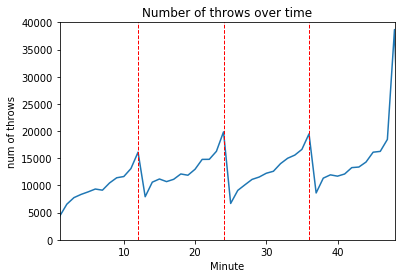

In [9]:
# Number of throws over time
plt.plot(minutes,total_throws)
plt.title('Number of throws over time')
plt.xlim([1,48])
plt.ylim([0, 40000])
plt.plot([12,12],[0,40000], '--', linewidth = 1, color = 'r')
plt.plot([24,24],[0,40000], '--', linewidth = 1, color = 'r')
plt.plot([36,36],[0,40000], '--', linewidth = 1, color = 'r')
plt.plot([48,48],[0,40000], '--', linewidth = 1, color = 'r')
plt.xlabel('Minute')
plt.ylabel('num of throws')

Text(0, 0.5, 'Free Throws %')

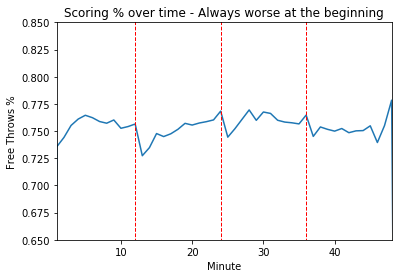

In [10]:
# Success throws precentage over time   
plt.plot(minutes,success_precentage)
plt.title('Scoring % over time - Always worse at the beginning')
plt.xlim([1,48])
plt.ylim([0.65,0.85])
plt.plot([12,12],[0,1], '--', linewidth = 1, color = 'r')
plt.plot([24,24],[0,1], '--', linewidth = 1, color = 'r')
plt.plot([36,36],[0,1], '--', linewidth = 1, color = 'r')
plt.plot([48,48],[0,1], '--', linewidth = 1, color = 'r')
plt.xlabel('Minute')
plt.ylabel('Free Throws %')

From the plots we can observe that at the begining of every querter, both the number of free throws and the success precentage drops.
Moreover, at the end of a quarter, and especially at the end of the game, both plots increase.
We can explain this behaivor, as basketball rules when a team made more than 5 fouls, every another foul made in that quarter will be penalty with a free throw.


### Analyzing the number of throws troughout the game
We want to see how the average of free throws attempted and succeed in games over our differents season in our dataset are distributed.

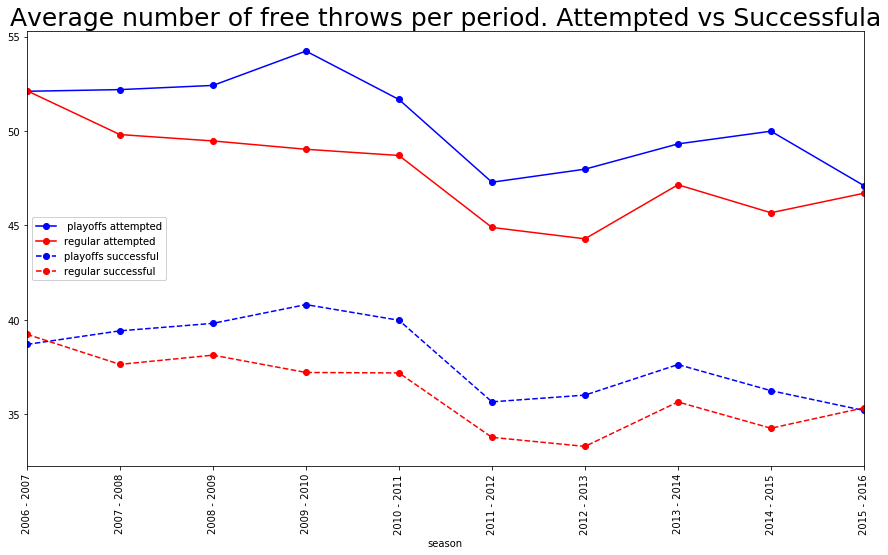

In [11]:
shot_attempted_per_game = database.groupby(["season", "playoffs"])['shot_made'].count().unstack()
shot_made_per_game = database.groupby(["season", "playoffs"])['shot_made'].sum().unstack()

# this has to be divided by the number of games for each season to get an average
number_of_games=database.groupby(["season", "playoffs"])['game_id'].nunique().unstack()

average_shot_made_per_game = shot_made_per_game/number_of_games
average_shot_attempted_per_game = shot_attempted_per_game/number_of_games


f, (ax1) = plt.subplots(figsize=(18,18))
first=average_shot_attempted_per_game.plot(ax=ax1, marker='o', figsize=(15,8), xticks=range(10), color=['b','r'], rot=90)
second=average_shot_made_per_game.plot(ax=ax1, marker='o', linestyle='--', figsize=(15,8), xticks=range(10), color=['b','r'], rot=90)
ax1.set_title('Average number of free throws per period. Attempted vs Successfula', size=25)
legend=plt.legend((' playoffs attempted','regular attempted','playoffs successful','regular successful'), loc=6)
ax1.add_artist(legend)
plt.show()

We can see that are not very big differences over the seasons at both attempted and successful shots.
But there is a clear difference between the amount of made shots and and successful shots at playoffs and regular season.


In [12]:
made_shot_perc , missed_shot_perc = database['shot_made'].value_counts(normalize=True) * 100
print("Made shots percentage in dataset: %.2f"%(made_shot_perc))
print("Missed shots percentage in dataset: %.2f"%(missed_shot_perc))


Made shots percentage in dataset: 75.68
Missed shots percentage in dataset: 24.32


### The correlation between the player's draft rank and the free-throw result

We wanted to check if there is a conection between the draft rank of the player performing the shot and the result of the shot. 
As we saw at the data description, we have some missing values in the draftRank column, and it was because the player throwing had no draft rank. 

As we can see below, the majoraty of the data in this column is avalable so we will ommit throws that were made by a players with no draft rank.

In [13]:
# the percentage of the data that has draftRank:
print(database['draftRank'].count()/database['game'].count())

0.9378142095954979


In [14]:
# Function that replace the field "undrafted" with a 0 in draftRank column

database['draftRank'] = database['draftRank'].replace(np.nan, 0)
database['draftRank'] = database['draftRank'].replace("undrafted", 0)
# pd.to_numeric(free_throws_db['draftRank'])
database['draftRank'] = database.draftRank.apply(lambda x: int(float(x)))

np.nanmax(database['draftRank'])

ranks = range(int(np.nanmax(database['draftRank']))+1)
success_precentage_by_rank = []

def throws_per_rank(database,rank):    
    total = len(database[database.draftRank == rank])
    if total == 0:
        precentage = 0.0
    else:
        made = len(database[(database.draftRank == rank) & (database.shot_made == 1)])
        precentage = made/total
    success_precentage_by_rank.append(precentage)

for rank in ranks:
    throws_per_rank(database,rank)

Text(0, 0.5, 'Free Throws %')

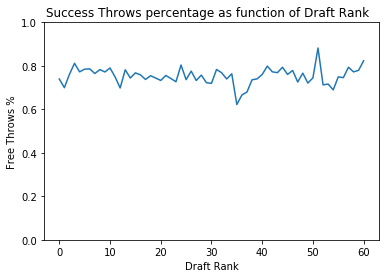

In [15]:
# Success throws precentage over time
plt.plot(list(ranks),success_precentage_by_rank)
plt.title('Success Throws percentage as function of Draft Rank  ')
plt.ylim([0,1])
plt.xlabel('Draft Rank')
plt.ylabel('Free Throws %')

As we see, there is no special trend in the graph (the FT% is between 0.7 to 0.9 for all ranks). We expected that the higher-ranked players would have better performence but we can't conclude it from the data. 

We have to take under consideration that the draft-rank data is not uniformly distributed, as we can see in the graph below, and is biased towared small values (the value 0 represents missing values, and in our case players who had no draft rank), so the barplot above needs to be normalized.

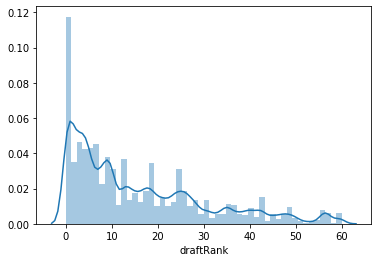

In [16]:
sns.distplot(database['draftRank'])

### The correlation between the score difference and the free-throw result

We will add a column calculating the differance.
We assume that if the difference is small in the time of the shot, the player would be more stressed and his shooting precentage would drop. 

In [17]:
database['scores'] = database.score.replace(' - ', '-').apply(lambda x: x.split('-'))
database['scoreDif'] = database.scores.apply(lambda x: int(x[1])-int(x[0]))
print(database['scoreDif'])

0          1
1          2
2         -6
3         -6
4         -9
          ..
309005    13
309006    14
309007    15
309008    15
309009    14
Name: scoreDif, Length: 618019, dtype: int64


In [18]:
difs = range(int(np.min(database['scoreDif']))+1,int(np.max(database['scoreDif']))+1)
success_precentage_by_scoreDif = []

def throws_per_dif(database,dif):    
    total = len(database[database.scoreDif == dif])
    if total == 0:
        precentage = 0.0
    else:
        made = len(database[(database.scoreDif == dif) & (database.shot_made == 1)])
        precentage = made/total
    success_precentage_by_scoreDif.append(precentage)

for dif in difs:
    throws_per_dif(database,dif)

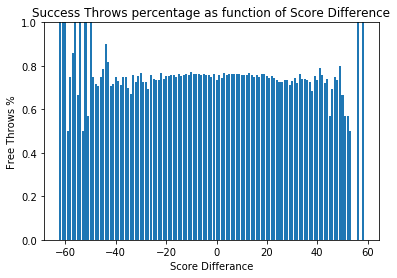

(-10, 10)

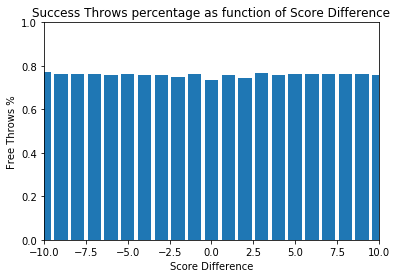

In [19]:
# Success throws precentage over time
plt.bar(list(difs),success_precentage_by_scoreDif)
plt.title('Success Throws percentage as function of Score Difference')
plt.ylim([0,1])
plt.xlabel('Score Differance')
plt.ylabel('Free Throws %')
plt.show()
plt.bar(list(difs),success_precentage_by_scoreDif)
plt.title('Success Throws percentage as function of Score Difference')
plt.ylim([0,1])
plt.xlabel('Score Difference')
plt.ylabel('Free Throws %')
plt.xlim(-10,10)

At the 'Success Throws percentage as function of Score Difference' plot, it seems that our hypotesis that as long as the score difference gets bigger, so as the free-throw success precentaege is partly true. 
We can see a trend in the graph but it is not continuous.

Furthermore, here too we have to relate to the fact that we have much more samples with low difference than high difference. 
As shown at graph below.

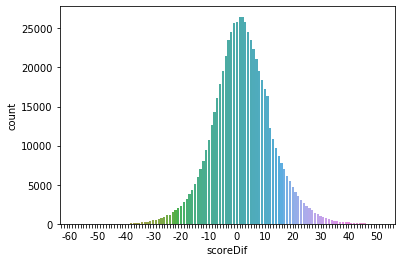

In [20]:
plot_ = sns.countplot(x='scoreDif', data=database)
for ind, label in enumerate(plot_.get_xticklabels()):
    if (ind-3) % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.show()

### The correlation between the player position and the free-throw result
We want to analyze if the "Position" feature of each player could be a helpful feature that may help our prediction model.
Above we can see a plot showing the distribution of the FT% over the different positions.

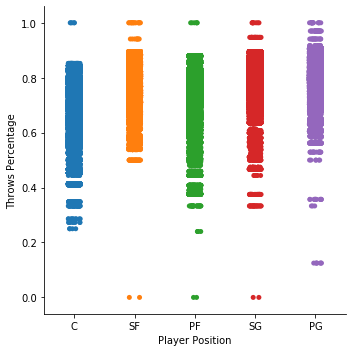

In [21]:
ax2 = sns.catplot(x="Pos", y="FT%", data=database);
#ax2 = sns.catplot(x="Pos", y="FT%",  kind="swarm", data=database);
ax2.set(xlabel='Player Position', ylabel='Throws Percentage')
plt.show()

Average FT% at each position

In [22]:
database.groupby('Pos').agg({'FT%':'mean'})

,FT%
Pos,
C,0.675366
PF,0.724143
PG,0.805380
SF,0.777317
SG,0.802994


We can see that Centers players owns the worst percentage.

Point Guards and Shouting Guards players holds the best percentage over all the positions.